# Introduction to Theano

This notebook contains the code snippets from the slides, so you can execute them and tinker with those examples.

To execute a cell: Ctrl-Enter.

The code was executed with the default configuration of Theano: `floatX=float64`, `device=cpu`. If you are executing the notebook with a different configuration in the `.theanorc` file, you can uncomment and execute the following cell.

In [ ]:
# import os
# os.environ['THEANO_FLAGS'] = 'floatX=float64,device=cpu'

# Symbolic expressions

## Declaring inputs

### Symbolic inputs

In [1]:
import theano
from theano import tensor as T
x = T.vector('x')
y = T.vector('y')

### Shared variables

In [2]:
import numpy as np
np.random.seed(42)
W_val = np.random.randn(4, 3)
b_val = np.ones(3)
W = theano.shared(W_val)
b = theano.shared(b_val)
W.name = 'W'
b.name = 'b'

## Defining expressions
### Build an expression

In [3]:
dot = T.dot(x, W)
out = T.nnet.sigmoid(dot + b)

C = ((out - y) ** 2).sum()
C.name = 'C'

In [4]:
from theano.printing import pydotprint
from IPython.display import Image, SVG

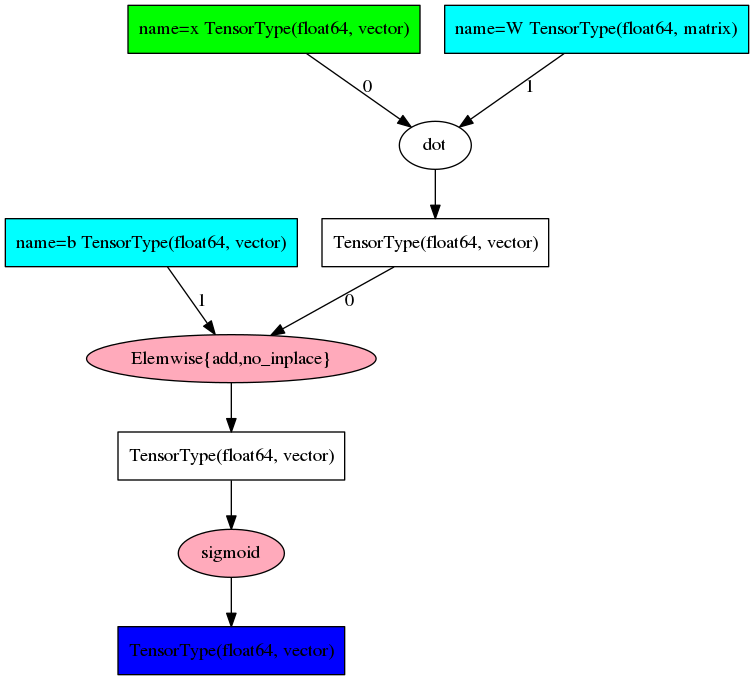

In [5]:
Image(pydotprint(out, format='png', compact=False, return_image=True))

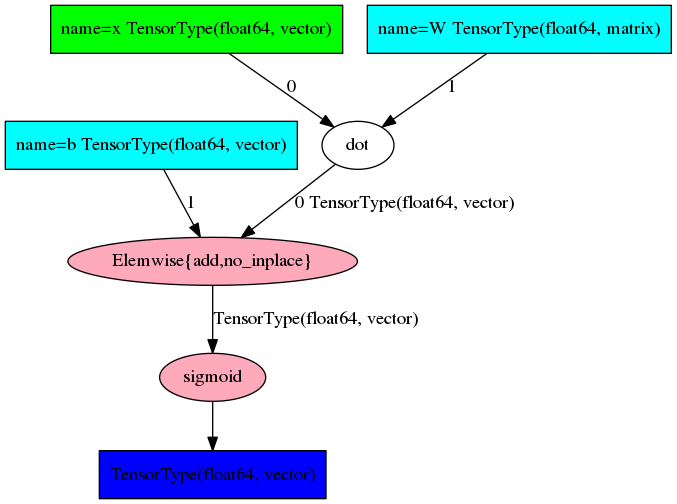

In [6]:
Image(pydotprint(out, format='png', return_image=True))

## Deriving gradients
### Using `theano.grad`

In [7]:
dC_dW, dC_db = theano.grad(C, [W, b])

### Computation graph with gradients

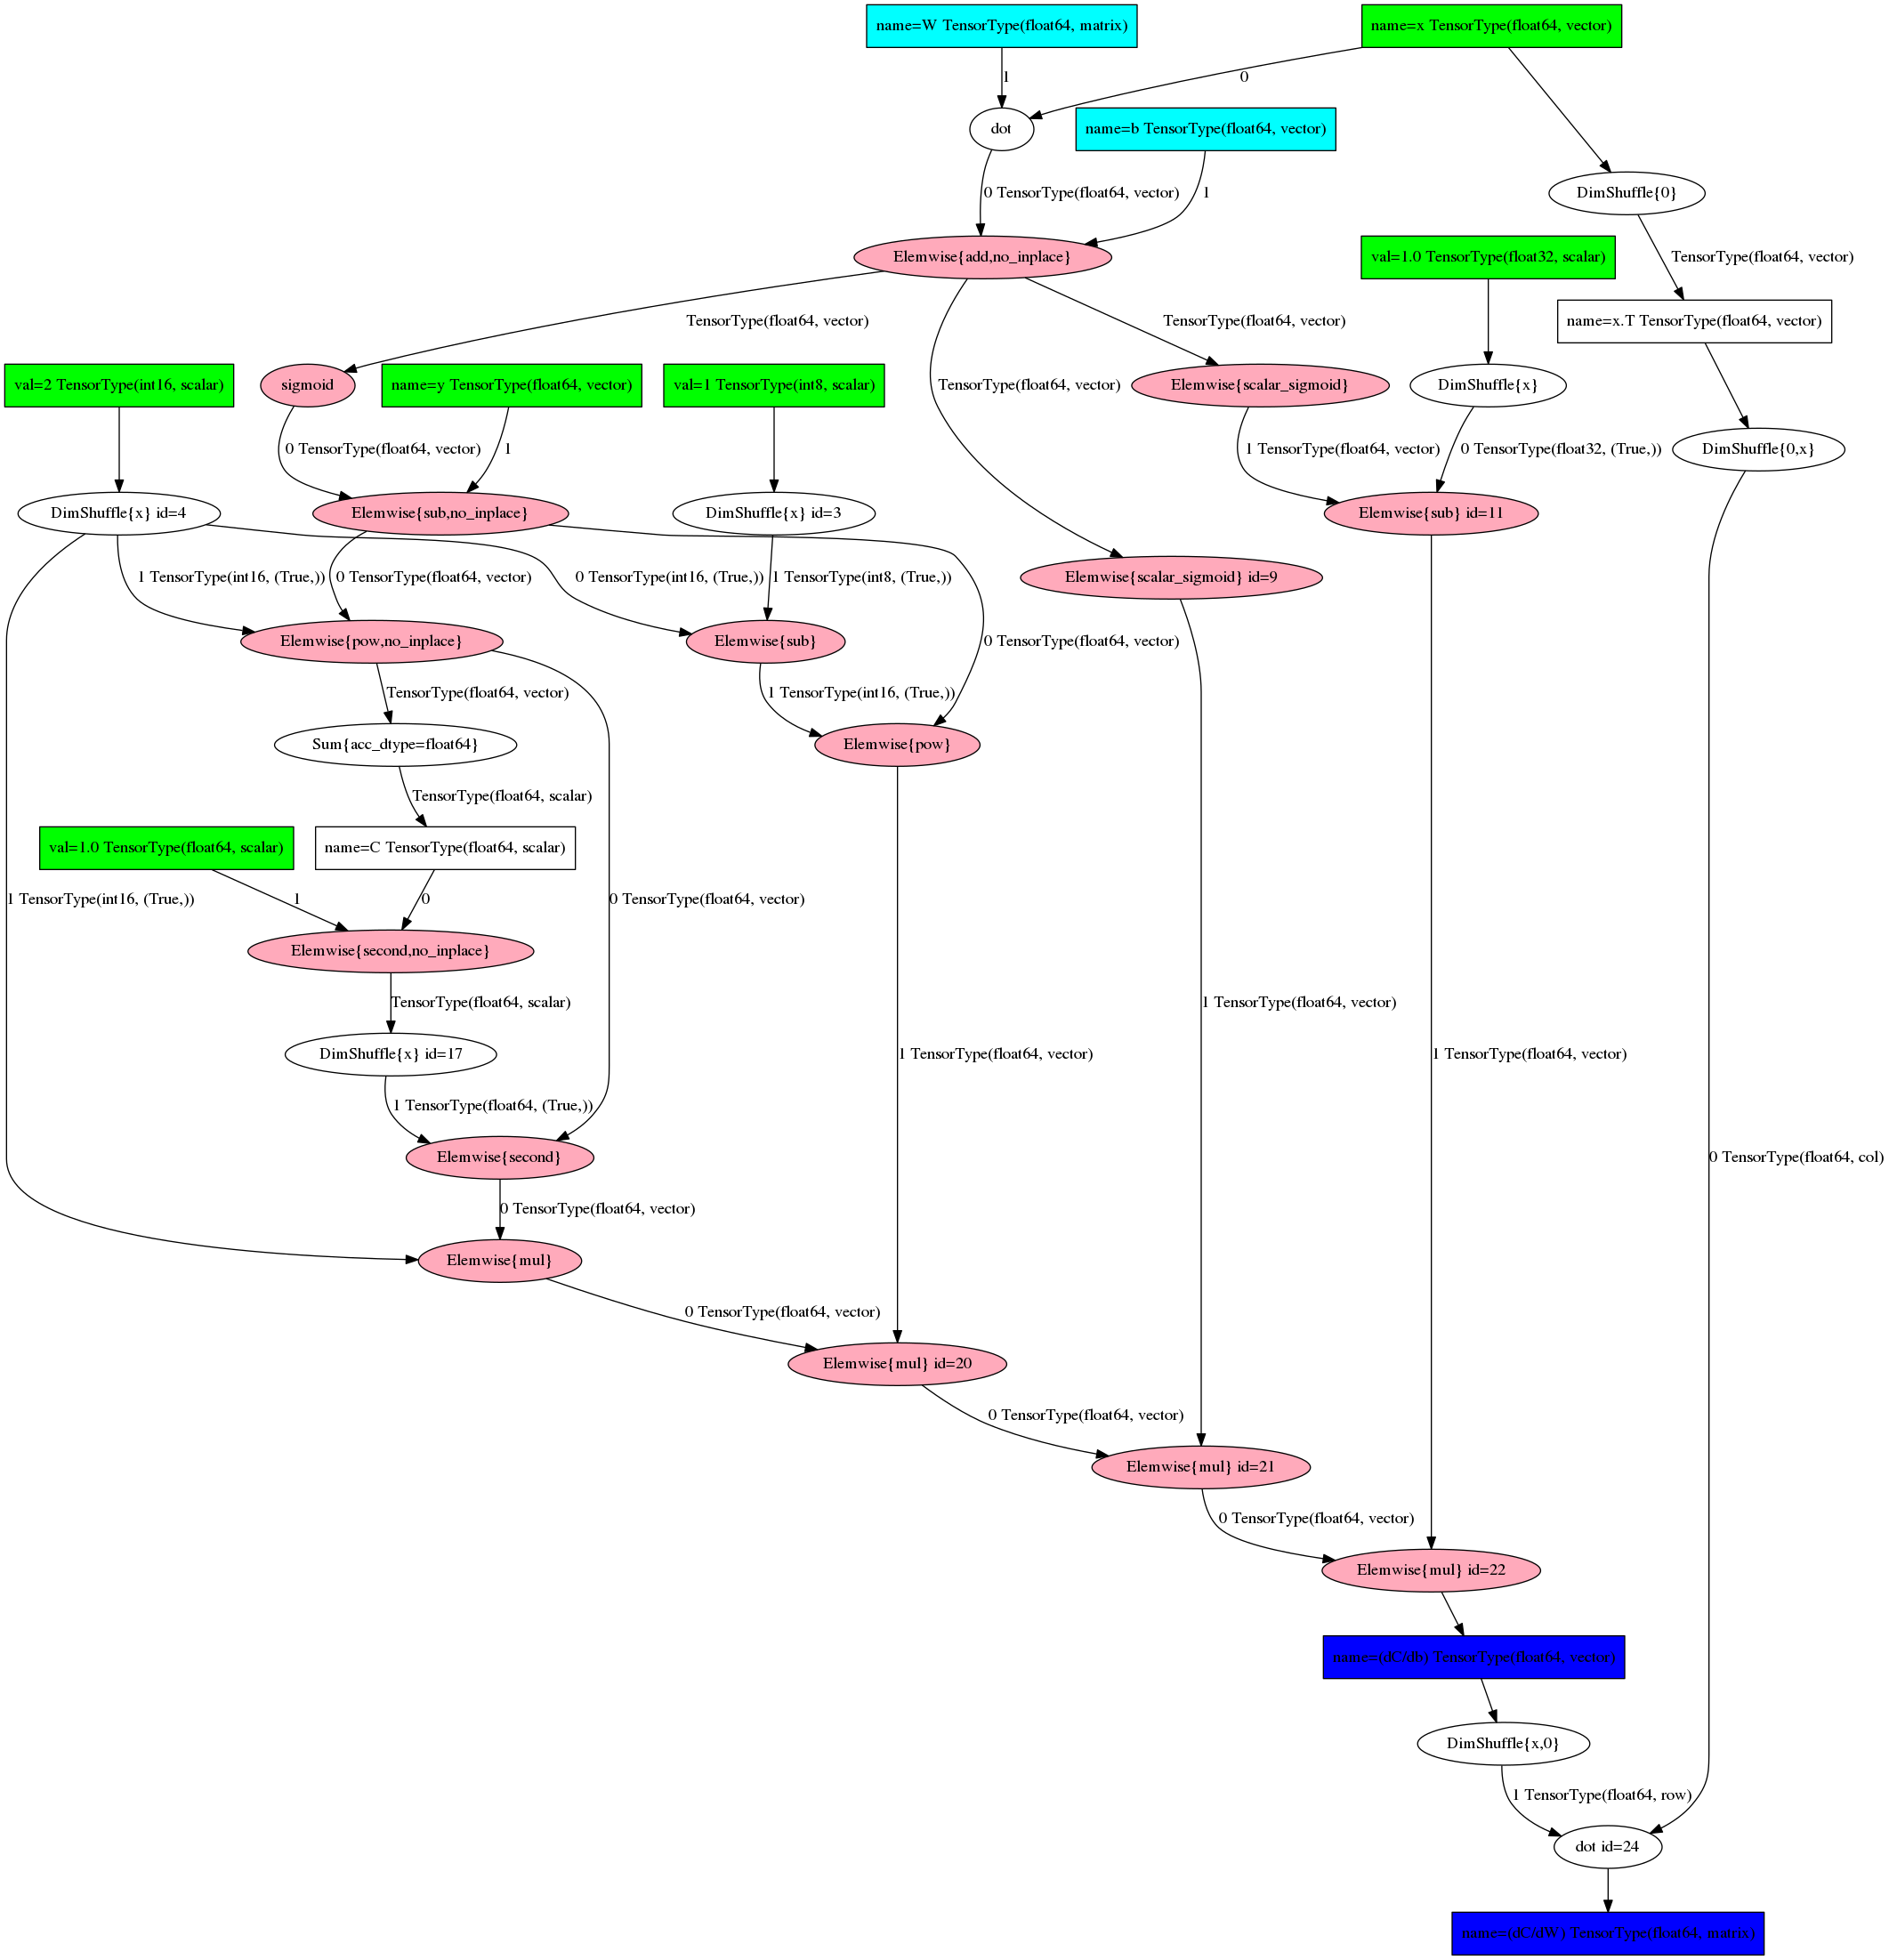

In [8]:
Image(pydotprint([dC_dW, dC_db], format='png', return_image=True), width=1000)

In [9]:
upd_W = W - 0.1 * dC_dW
upd_b = b - 0.1 * dC_db

### Computation graph with updates

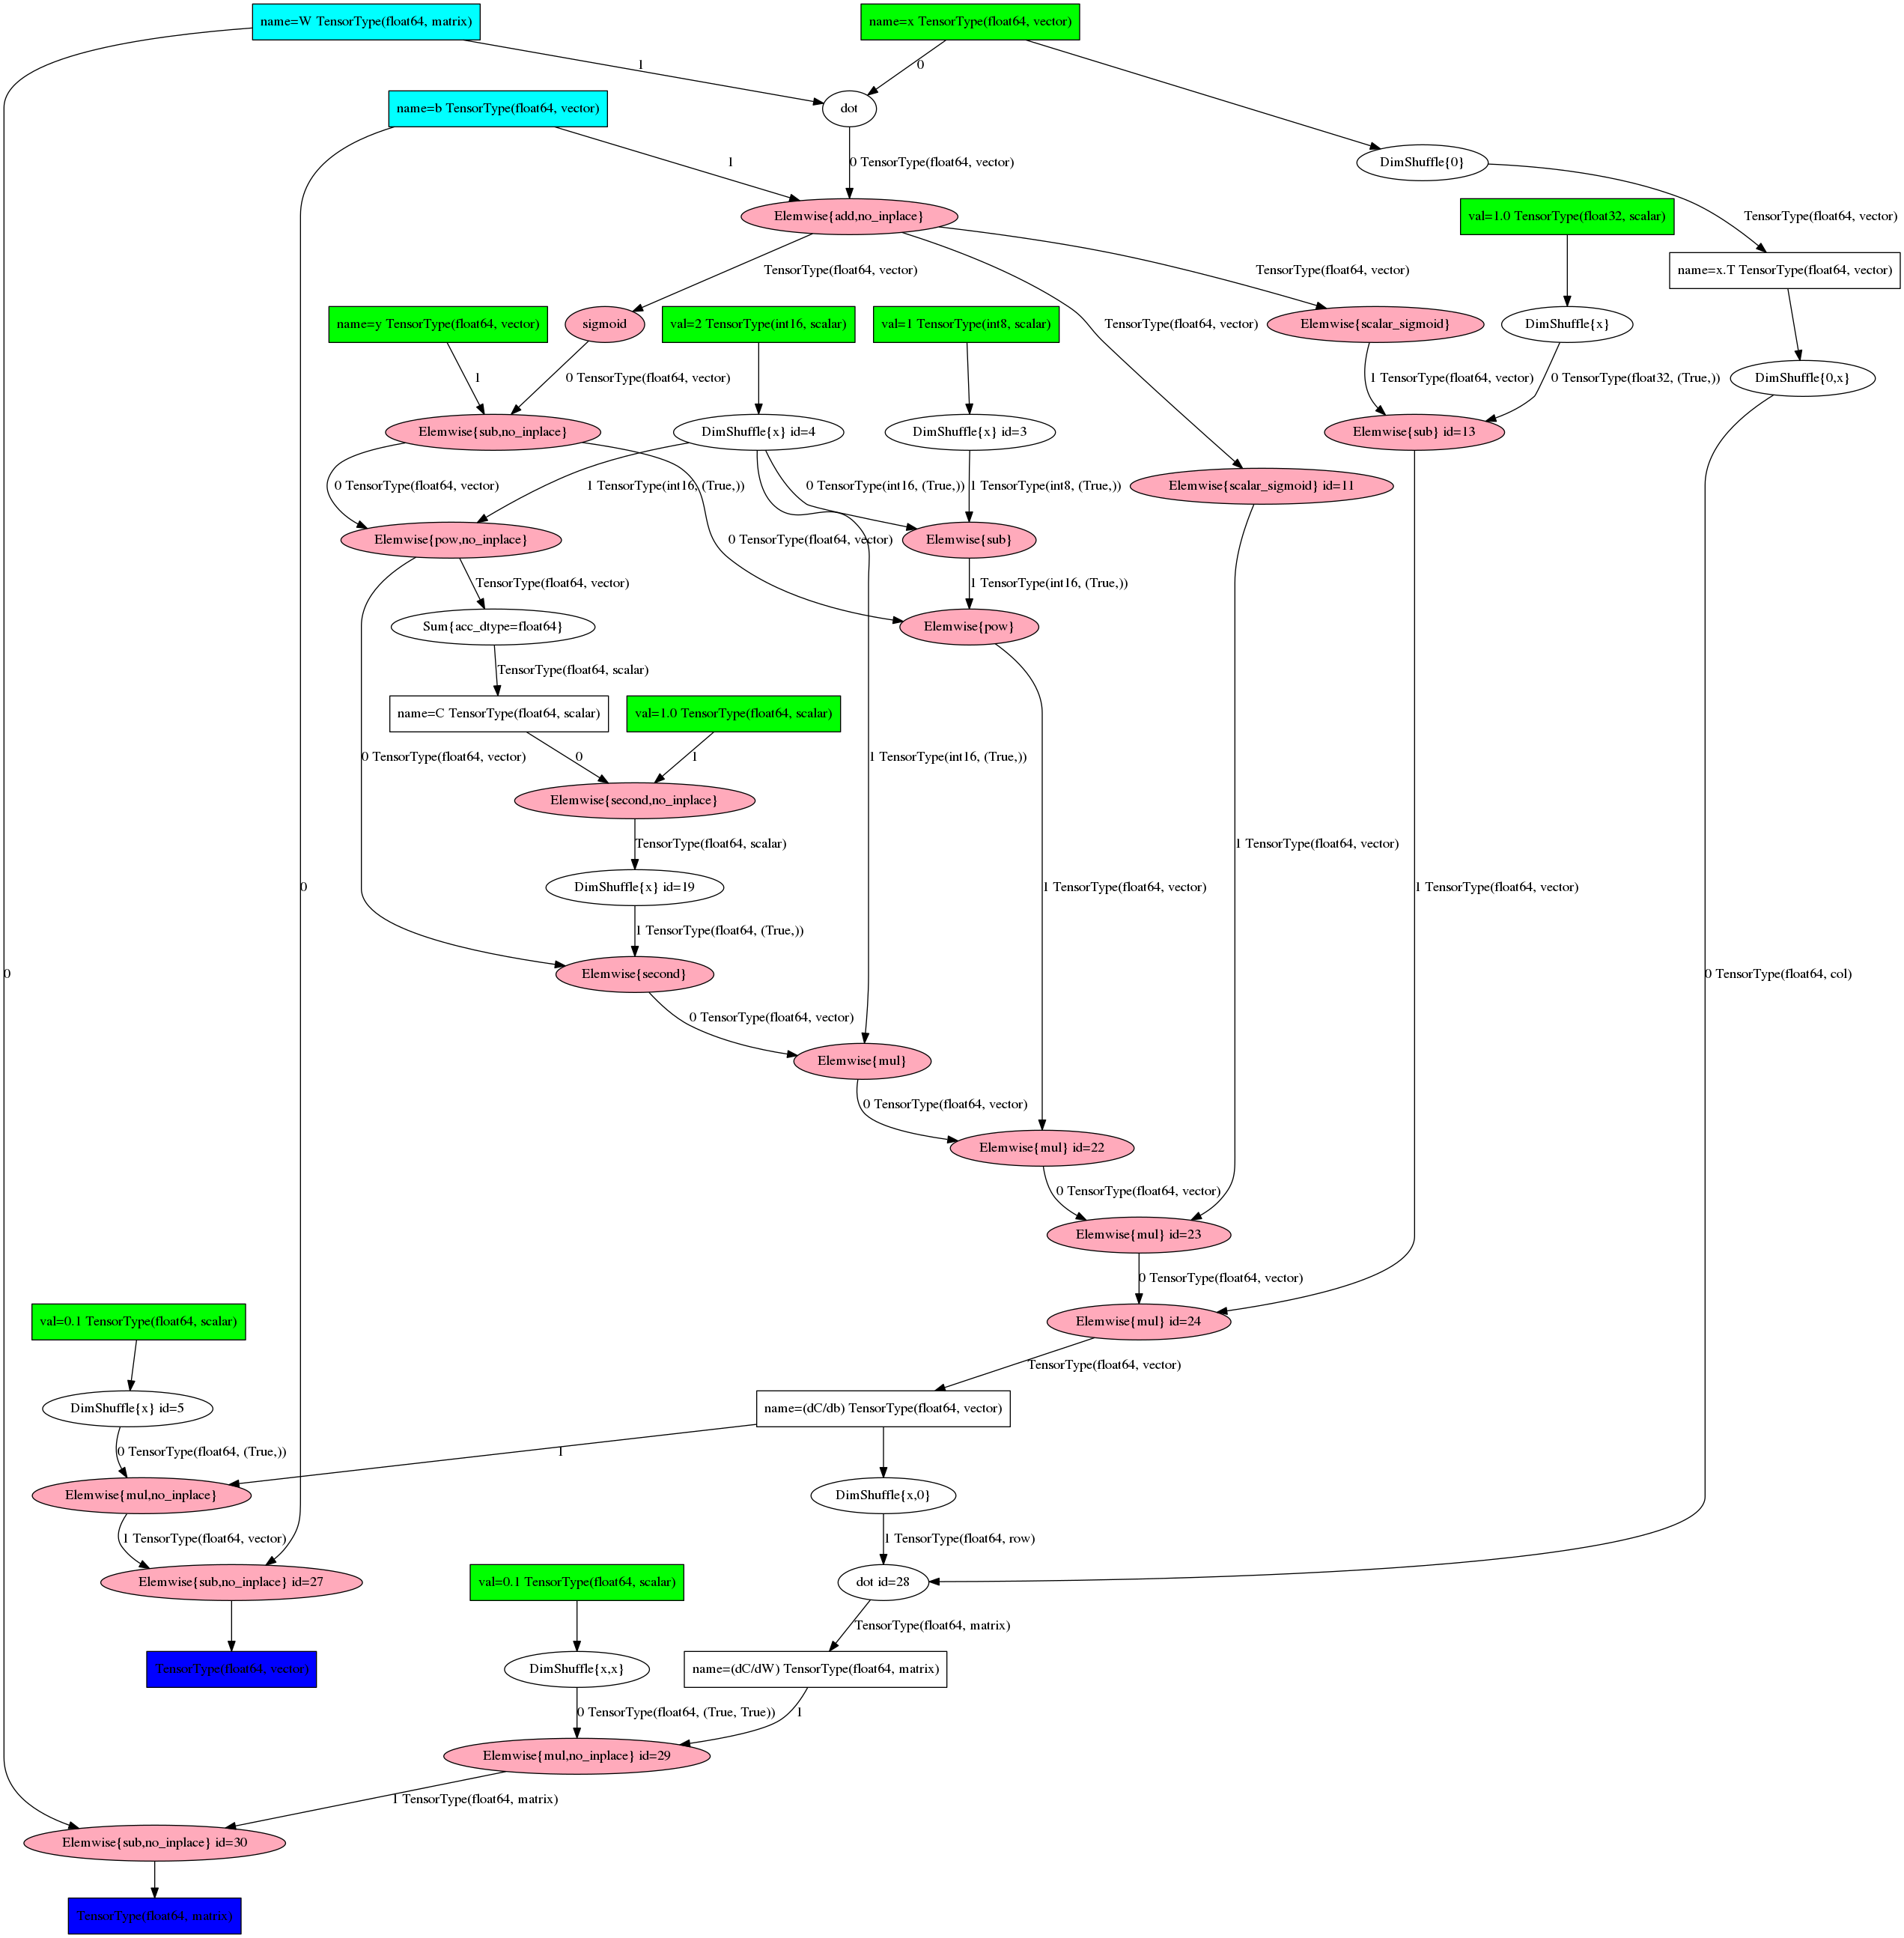

In [10]:
Image(pydotprint([upd_W, upd_b], format='png', return_image=True), width=1000)

# Function compilation
## Compiling a Theano function
### Computing values

In [11]:
predict = theano.function([x], out)
x_val = np.random.rand(4)
print(predict(x_val))

[ 0.9421594   0.73722395  0.67606977]


In [12]:
monitor = theano.function([x, y], [out, C])
y_val = np.random.uniform(size=3)
print(monitor(x_val, y_val))

[array([ 0.9421594 ,  0.73722395,  0.67606977]), array(0.6137821438190066)]


In [13]:
error = theano.function([out, y], C)
print(error([0.942, 0.737, 0.676], y_val))

0.613355628529845


### Updating shared variables

In [14]:
train = theano.function([x, y], C,
                        updates=[(W, upd_W),
                                 (b, upd_b)])
print(b.get_value())
print(W.get_value())

[ 1.  1.  1.]
[[ 0.49671415 -0.1382643   0.64768854]
 [ 1.52302986 -0.23415337 -0.23413696]
 [ 1.57921282  0.76743473 -0.46947439]
 [ 0.54256004 -0.46341769 -0.46572975]]


In [15]:
train(x_val, y_val)
print(b.get_value())
print(W.get_value())

[ 0.99639999  0.97684097  0.98318412]
[[ 0.49561888 -0.14531026  0.64257244]
 [ 1.52114073 -0.24630622 -0.2429612 ]
 [ 1.57765781  0.7574313  -0.47673792]
 [ 0.54151161 -0.47016228 -0.47062703]]


## Graph visualization
### Comparing `out` with `predict`

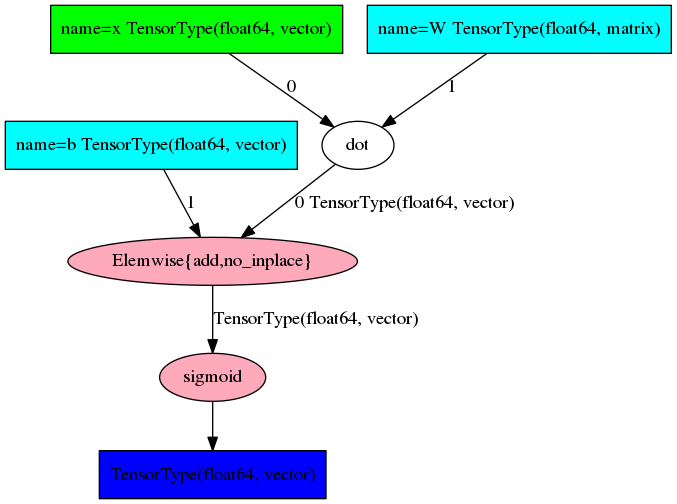

In [16]:
Image(pydotprint(out, format='png', return_image=True))

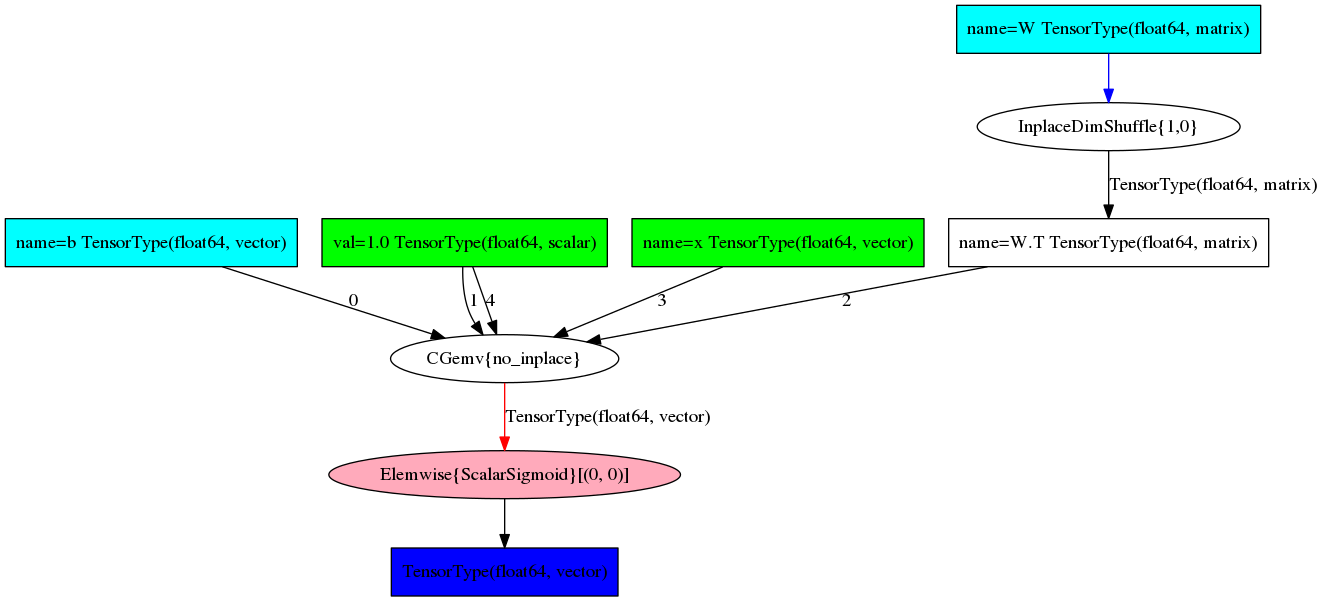

In [17]:
Image(pydotprint(predict, format='png', return_image=True))

### Comparing `upd_*` with `train`

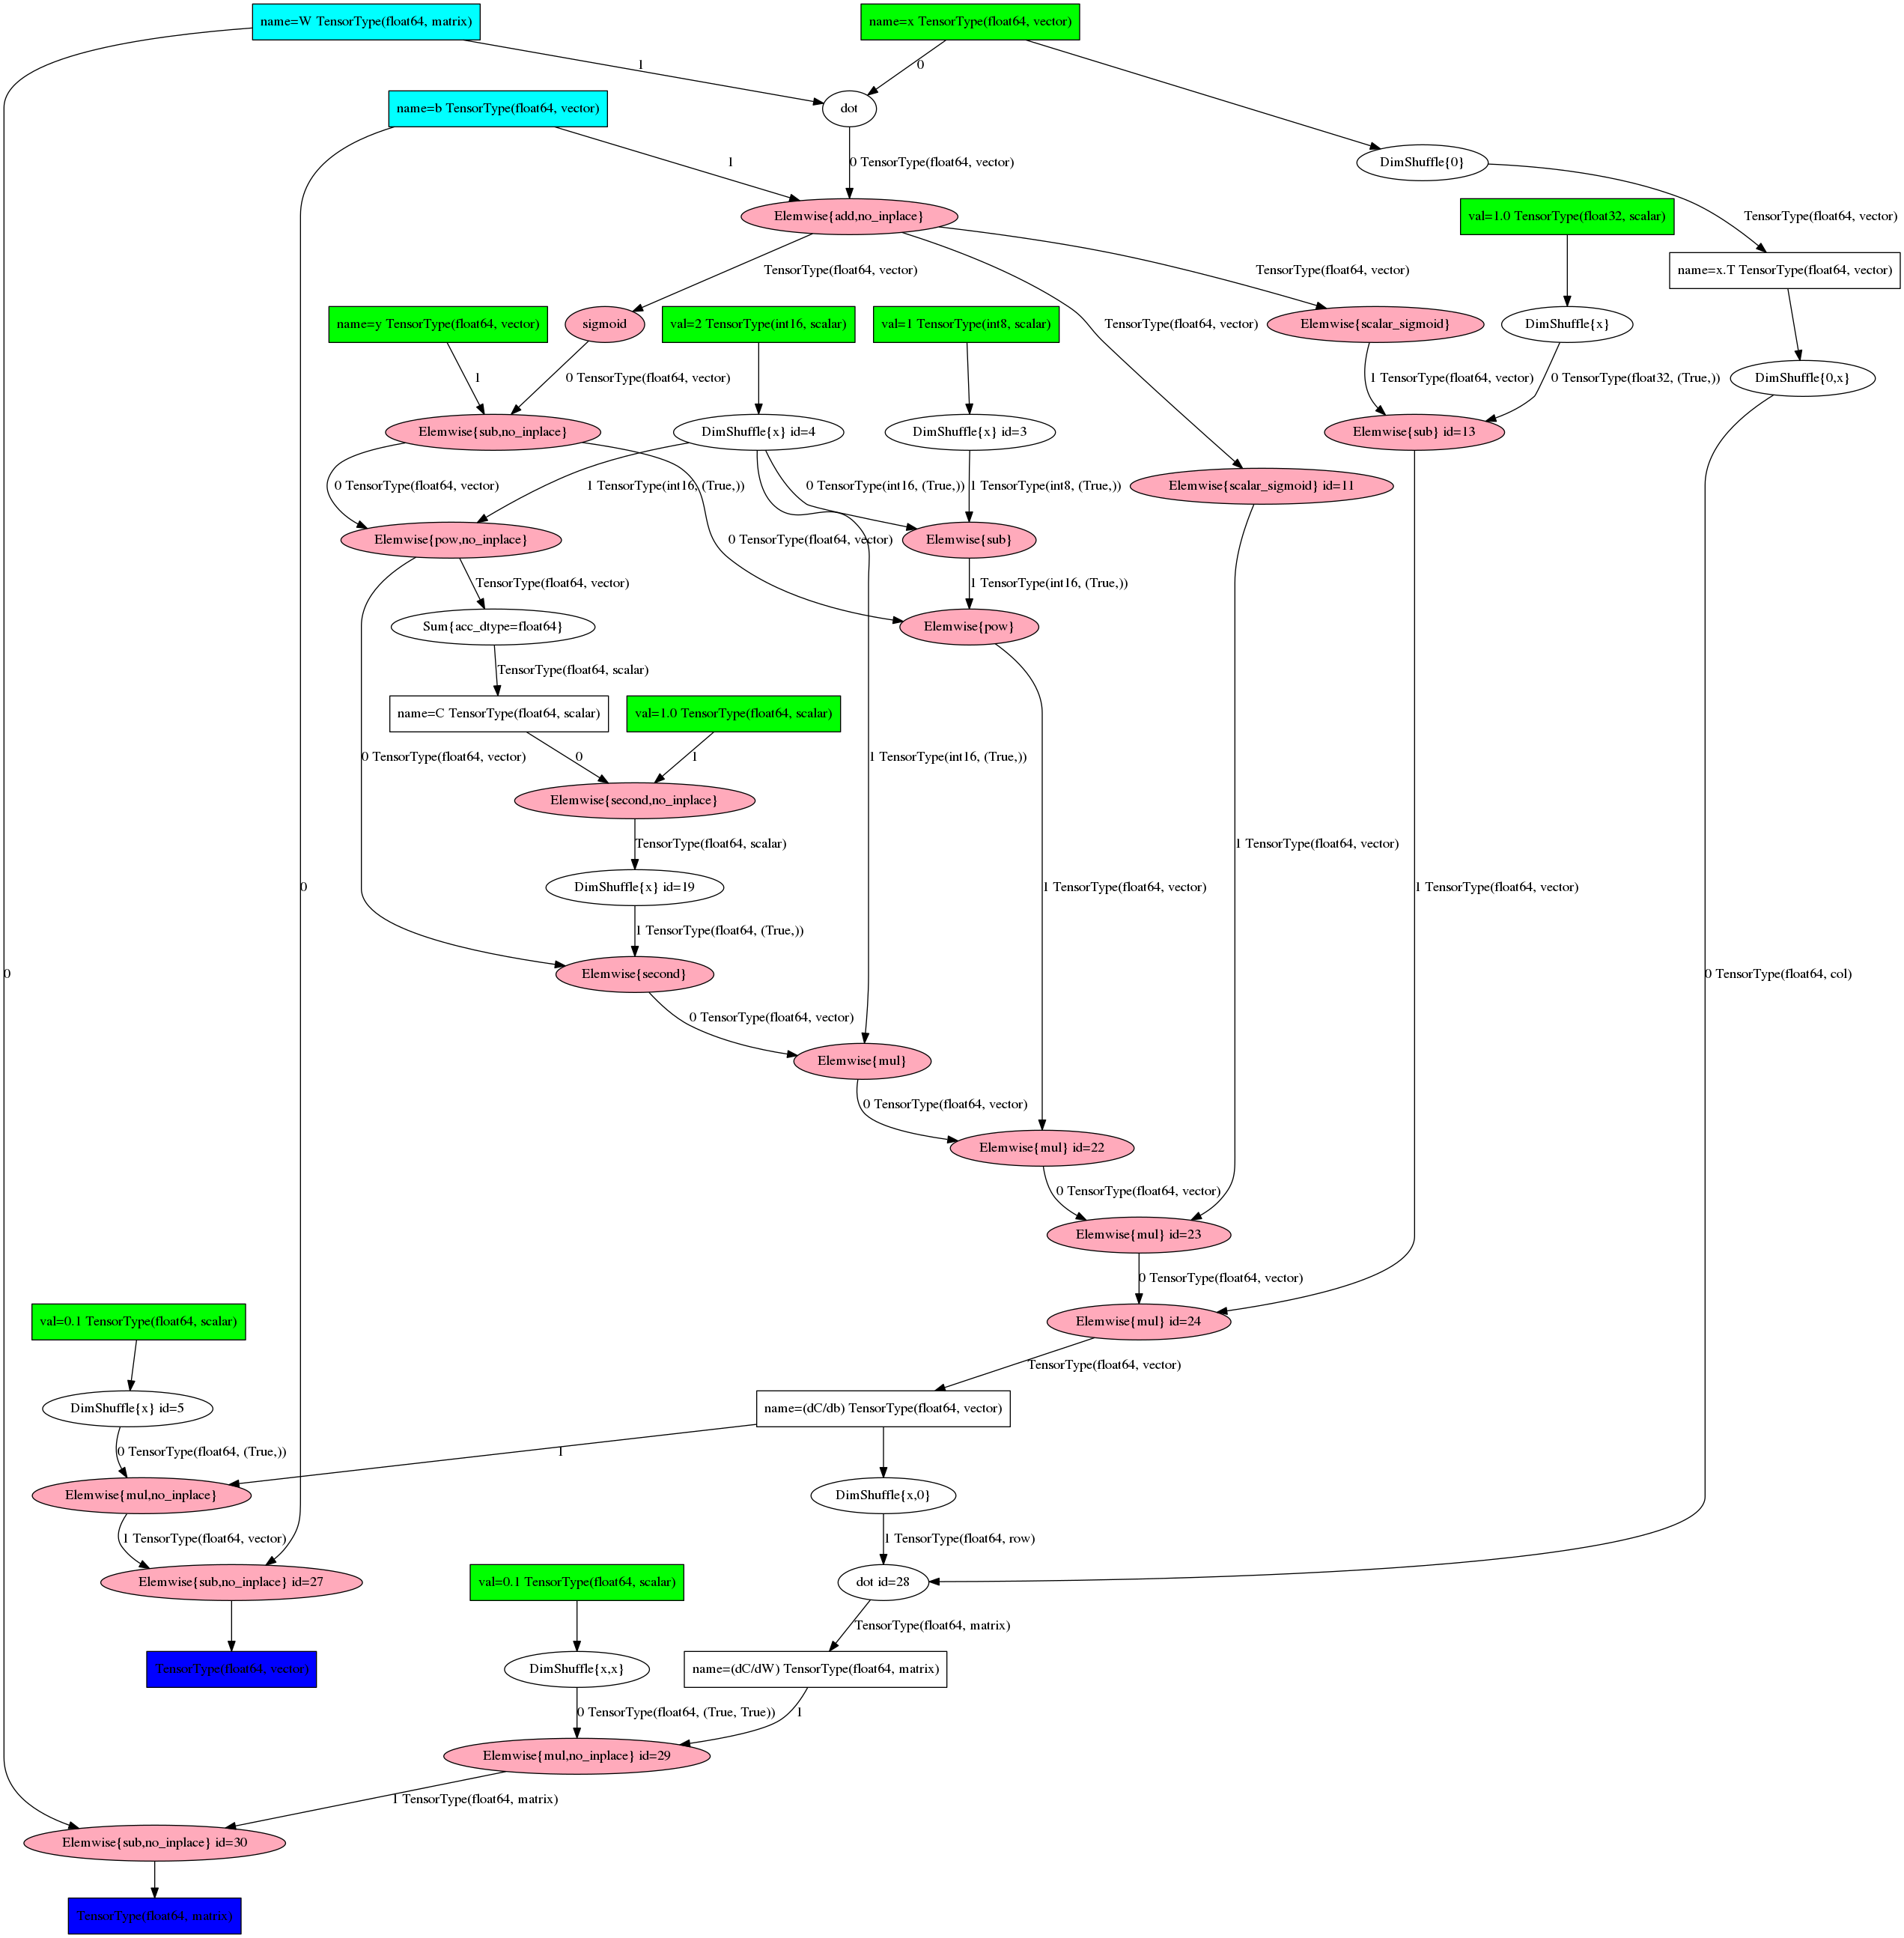

In [18]:
Image(pydotprint([upd_W, upd_b], format='png', return_image=True), width=1000)

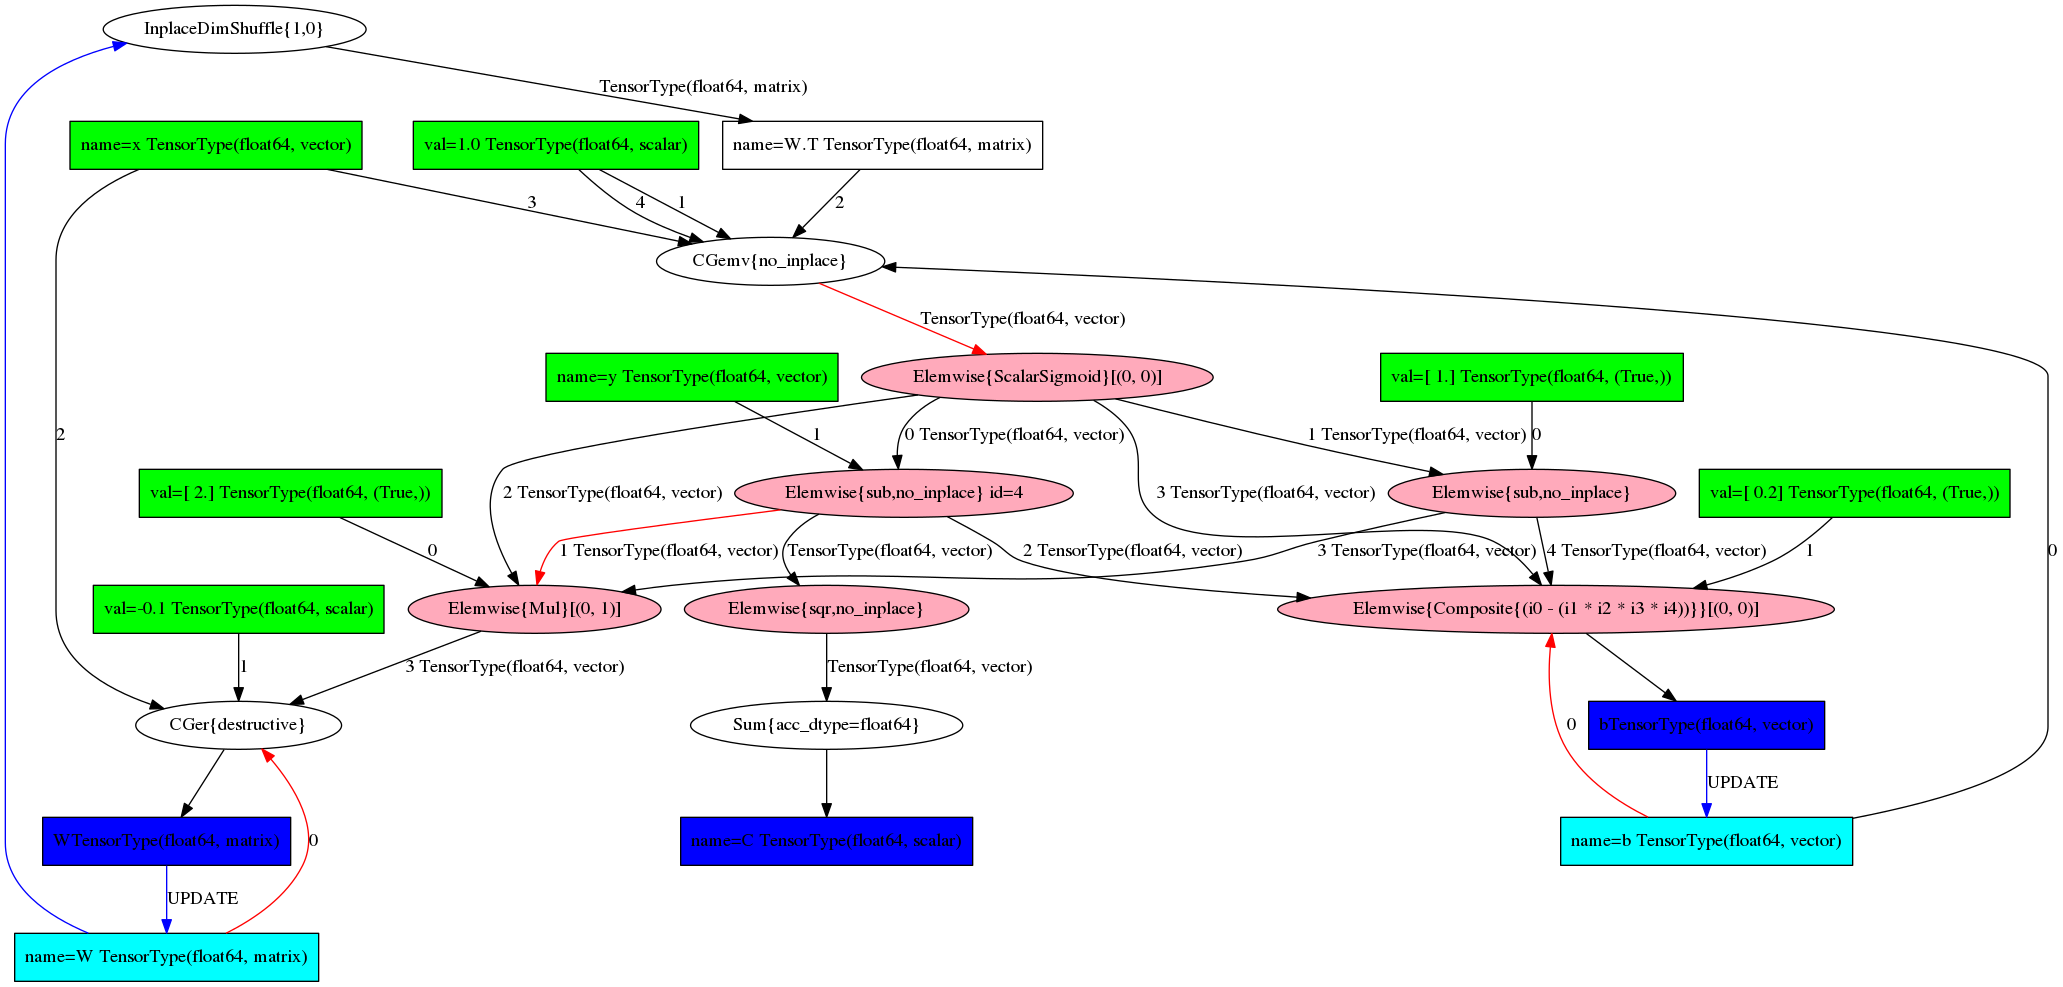

In [19]:
Image(pydotprint(train, format='png', return_image=True), width=1000)

### `debugprint`

In [20]:
from theano.printing import debugprint
debugprint(out)

sigmoid [id A] ''   
 |Elemwise{add,no_inplace} [id B] ''   
   |dot [id C] ''   
   | |x [id D]
   | |W [id E]
   |b [id F]


In [21]:
debugprint(predict)

Elemwise{ScalarSigmoid}[(0, 0)] [id A] ''   2
 |CGemv{no_inplace} [id B] ''   1
   |b [id C]
   |TensorConstant{1.0} [id D]
   |InplaceDimShuffle{1,0} [id E] 'W.T'   0
   | |W [id F]
   |x [id G]
   |TensorConstant{1.0} [id D]


# Advanced Topics
## Looping: the `scan` operation
### Example: Loop with accumulation

In [22]:
k = T.iscalar("k")
A = T.vector("A")

# Symbolic description of the result
result, updates = theano.scan(fn=lambda prior_result, A: prior_result * A,
                              outputs_info=T.ones_like(A),
                              non_sequences=A,
                              n_steps=k)

# We only care about A**k, but scan has provided us with A**1 through A**k.
# Discard the values that we don’t care about. Scan is smart enough to
# notice this and not waste memory saving them.
final_result = result[-1]

# compiled function that returns A**k
power = theano.function(inputs=[A, k], outputs=final_result, updates=updates)

print(power(range(10), 2))

[  0.   1.   4.   9.  16.  25.  36.  49.  64.  81.]


In [23]:
print(power(range(10), 4))

[  0.00000000e+00   1.00000000e+00   1.60000000e+01   8.10000000e+01
   2.56000000e+02   6.25000000e+02   1.29600000e+03   2.40100000e+03
   4.09600000e+03   6.56100000e+03]


## Next tutorials:
- [Logistic regression](logistic_regression.ipynb) on MNIST
- [ConvNet](convnet/lenet.ipynb) on MNIST
- [LSTM](lstm/lstm_text.ipynb) for character-level text generation